# Predicting water solubility - Part II?

> Feature selection

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/glass.jpg

Water solubility is one onf the main players in lead optimization. If a molecule is not soluble, we might have problems in biological assays and also to make it reach the desired target in vivo. 

This post is the first of a series that will end with a prediction model to estimate water solubility. In this first notebook, we will see some exploratory data analysis and how to prepare a dataset for modeling. 

# Requirements

 - rdkit >= 2020.09.1
 - pandas >= 1.1.3
 - seaborn
 - matplotlib
 - fastcore (!conda install fastcore)


In this tutorial we'll use a dataset compiled by [Sorkun et al (2019)](https://www.nature.com/articles/s41597-019-0151-1) from multiple projects to predict water solubility. You can download the original dataset from [here](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/OVHAW8).

> ```At the end of the notebook I added a class to process the original dataset in order to remove salts, mixtures, neutralize charges and generate canonical SMILES. I highly recommend checking each structure before modeling. ```

In this notebook we'll cover three main topics:

   - **Featurization of molecules**
   - **What's the correlation between features?**
   - **Feature selection methods**
   - **Feature transformation**

# Background

Drug solubility is a critical factor in drug development. If a drug is not soluble enough or doesn't dissolve readily its intestinal absoption will be compromised, leading to low concentration in the blood circulation and reduced (or none) biological activity. 

Crystal formation of low soluble drugs may also lead to toxicity. In practical terms, poor solubility is one of the factors that lead to fail in drug discovery projects. Therefore, medicinal chemists work hard to design molecules tha have the intended bioactivity and that can display the desired effect in vivo. 

Despite being conceptually easy to understand solubility, its estimation isn't that friendly. That's because the intrinsic solubility of a molecule depends on many factors, including its size, shape, the ability to make intermolecular interactions, crystal packing

# Import modules

In [1]:
#collapse
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.preprocessing import Normalizer, normalize, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.feature_selection import mutual_info_regression, RFECV,SelectFromModel,RFE,VarianceThreshold
from functools import partial
from pathlib import Path
from joblib import load, dump

from scipy import stats
from scipy.stats import norm
from statsmodels.graphics.gofplots import qqplot
from rdkit.Chem import Draw
from rdkit.Chem import MolFromSmiles, MolToSmiles

from descriptastorus.descriptors.DescriptorGenerator import MakeGenerator


In [2]:
np.random.seed(5)

In [3]:
sns.set(rc={'figure.figsize': (16, 16)})
sns.set_style('whitegrid')
sns.set_context('paper',font_scale=1.5)

# Load Data

In [31]:
data = pd.read_csv('../_data/water_solubility_nooutliers.csv')
esol = pd.read_csv('/home/marcossantana/Documentos/GitHub/ADMETBox/data/moleculenet/ESOL/esol_9_rdkit2Dnormalized_features.csv')

In [5]:
#collapse_output
data.head()

ID                                               Name  \
0   A-4                           Benzo[cd]indol-2(1H)-one   
1   A-5                               4-chlorobenzaldehyde   
2  A-10                                       vinyltoluene   
3  A-11               3-(3-ethylcyclopentyl)propanoic acid   
4  A-12  11,16,17,21-tetrahydroxypregna-1,4-diene-3,20-...   

                                               InChI  \
0  InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...   
1        InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H   
2  InChI=1S/C9H10/c1-3-9-6-4-5-8(2)7-9/h3-7H,1H2,2H3   
3  InChI=1S/C10H18O2/c1-2-8-3-4-9(7-8)5-6-10(11)1...   
4  InChI=1S/C21H28O6/c1-19-6-5-12(23)7-11(19)3-4-...   

                      InChIKey  \
0  GPYLCFQEKPUWLD-UHFFFAOYSA-N   
1  AVPYQKSLYISFPO-UHFFFAOYSA-N   
2  JZHGRUMIRATHIU-UHFFFAOYSA-N   
3  WVRFSLWCFASCIS-UHFFFAOYSA-N   
4  SEKYBDYVXDAYPY-UHFFFAOYSA-N   

                                              SMILES  Solubility   SD  \
0                               O=C1Nc2cccc3cccc1c23   -3.254767  0.0   
1                                    Clc1ccc(C=O)cc1   -2.177078  0.0   
2                                     Cc1cccc(C=C)c1   -3.123150  0.0   
3                                CCC1CCC(CCC(O)=O)C1   -3.286116  0.0   
4  CC12CC(O)C3C(CCC4=CC(=O)C=CC34C)C1CC(O)C2(O)C(...   -2.664549  0.0   

   Ocurrences Group    MolWt  ...  NumValenceElectrons  NumAromaticRings  \
0           1    G1  169.183  ...                 62.0               2.0   
1           1    G1  140.569  ...                 46.0               1.0   
2           1    G1  118.179  ...                 46.0               1.0   
3           1    G1  170.252  ...                 70.0               0.0   
4           1    G1  376.449  ...                148.0               0.0   

   NumSaturatedRings  NumAliphaticRings  RingCount    TPSA   LabuteASA  \
0                0.0                1.0        3.0   29.10   75.183563   
1                0.0                0.0        1.0   17.07   58.261134   
2                0.0                0.0        1.0    0.00   55.836626   
3                1.0                1.0        1.0   37.30   73.973655   
4                3.0                4.0        4.0  115.06  158.135542   

   BalabanJ     BertzCT                                   processed_smiles  
0  2.582996  511.229248                               O=C1Nc2cccc3cccc1c23  
1  3.009782  202.661065                                    O=Cc1ccc(Cl)cc1  
2  3.070761  211.033225                                     C=Cc1cccc(C)c1  
3  2.145839  153.917569                                CCC1CCC(CCC(=O)O)C1  
4  1.776978  755.770792  CC12C=CC(=O)C=C1CCC1C2C(O)CC2(C)C1CC(O)C2(O)C(...  

[5 rows x 27 columns]

# Featurization

In this dataset 17 features were already calculated for each molecule. These features include a range of physichochemical properties (e.g. MolWt, MolLogP and MolMR), atomic counts (e.g. HeavyAtomCount, NumHDonors and Acceptors) more abstract topological descriptors (e.g. BalabanJ, BertzCT).

In [6]:
descriptors = ['MolWt', 'MolLogP', 'MolMR', 'HeavyAtomCount',
       'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds',
       'NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings',
       'NumAliphaticRings', 'RingCount', 'TPSA', 'LabuteASA', 'BalabanJ',
       'BertzCT']

In [7]:
print(len(descriptors))

17


We can check the correlation between each feature and solubility using seaborn's regplot:

In [8]:
nr_rows = 6
nr_cols = 3
target = 'Solubility'

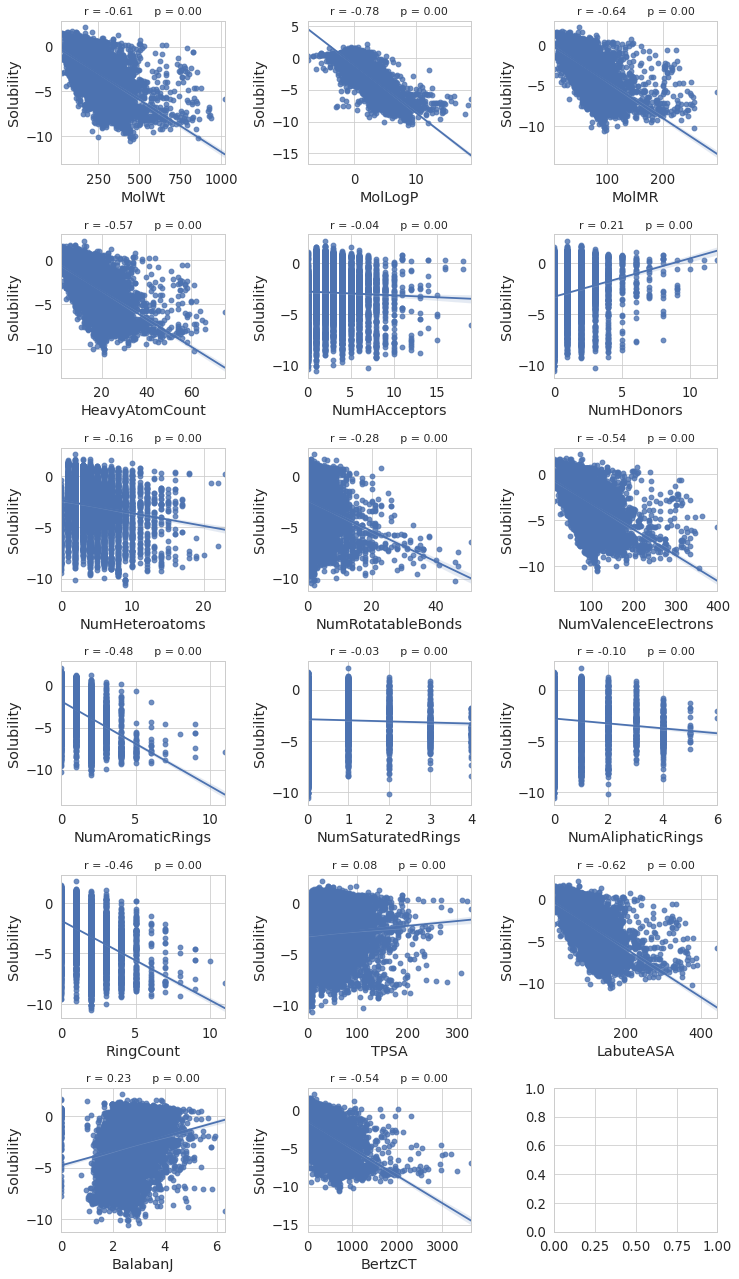

In [9]:
#hide_input
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        
        if i < len(descriptors):
            
            sns.regplot(x=data[descriptors[i]], y=data[target], ax = axs[r][c])
            
            stp = stats.pearsonr(data[descriptors[i]], data[target])

            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()  

Most have a negative correlation with solubility. In fact, the available features reflect more or less the size/complexity of the molecule (e.g. MolWt, RingCount, MolMR) and it's capacity to make inter and intramolecular interactions (e.g., NumValenceElectrons, NumHAcceptors, NumHDonors, MolLogP), which are known to influence water solubility. For instance, bigger molecules tend to be less soluble in water (high MolMW and HeavyAtomCount); the same applies for very liphophilic (high MolLogP) molecules. On the other hand, more polar molecules, capable of making hydrogen bonds with water molecules, are usually more soluble. 

Based on this preliminary analysis we can start thinking which features to include when training a regression model. For instance, molecular weight and liphophilicity are the features most correlated with the target variable. These features have a strong influence in solubility as demonstrated experimentally and by theorical calculations. As the molecular size and liphophilicity grows, its much harder to dissolve a molecule in water because the solute needs to disrupt a great number interactions within solvent molecules and force its way into bulk water, which demands a great amount of energy. The [influence of lipophilicity](https://pubs.acs.org/doi/10.1021/jo01265a071) is so well known that its part of many predictive models, such as the famous [ESOL (estimated solubility)](https://pubs.acs.org/doi/10.1021/ci034243x), which estimates water solubility based only on the molecular structure. 

```Back in the day (2003!) the author didn't even use the robust machine learning algorithms we have today to derive the following equation:```

$$logS_{w} = 0.16 - 0.63logP - 0.0062MolWt + 0.066Rot - -0.74AP$$

where $logS_{w}$ is the log of the water solubility, $logP$ is the lipophilicity, $MolWt$ is the molecular weight, $Rot$ is the number of rotatable bonds (e.g. single bonds) and $AP$ is the proportion of heavy atoms that are part of aromatic rings. 

ESOL is a very simple and useful model; and I've used it multiple times. In the post we'll use ESOL as a baseline against different machine learning algorithms, but for now it's suffice to consider the features used to train the model and how they affect solubility. 

# Understanding the features

## 1) LogP


The logP is the partition coefficient given by:

$$logP = \frac{C_{n-octanol}}{C_{water}}$$

where $C_{n-octanol}$ and $C_{water}$ are the solute concentration in the n-octanol and water, respectively. Thus, higher logP means that a smaller concentration of the molecule is available in the water phase of a system, which makes it more lipophilic or hydrophobic.  

## 2) Molecular weight

Molecular weight (MolWt) is simply the total mass of a mole of a compound (molar mass). The MolWt can be calculated by the summing the contribution of each atom in a molecule. For example, the molar weight of water is:

$$H_{2}O = 2H * (1.01) + 1O * (16) = 18.01 g/mol$$

## 3) Molar refractivity

Molar refractivity (MolMR) is the refractivity of a mole of a substance. It's given by the formula:

$$MolMR = \frac{n^{2}-1}{n^{2}+2}*\frac{MolWt}{d}$$

where $MolWt$ is the molar weight, $d$ is the density and $n$ is the refractivity index. The right hand side of the equation ($\frac{MolWt}{d}$) is the volume. Thus, the molar refractivity encodes the molecular volume and is a way to estimate the steric bulk. 

## 4) Topological polar surface area (TPSA) and LabuteASA


 - **TPSA**: The polar surface area is the sum of the surfaces of polar atoms in a molecule, such as oxygen and nitrogen, and sometimes sulphur and its hydrogen. The total polar surface area is a useful feature to encode both the polarity and the hydrogen bonding capacity of a molecule. 
 

 - **LabuteASA**: the accessible surface area (ASA) is the area of a molecule that is accessible to the solvent (e.g. water). If we consider a water molecule as a ball rolling on the solute structure, the ASA is represented by all parts the water ball can interact with. 

![TPSA](https://docs.eyesopen.com/toolkits/cookbook/python/_images/psa2img.png)

**Figure 1**. Representation of the polar surface area, showing the contributions of each polar atom in the molecule.

![TPSA](images/asa.png)

**Figure 2**. Representation of the polar surface area, showing the contributions of each polar atom in the molecule.

Labute's Approximate Surface Area

## 5) Atomic counts

Atomics counts represent the number of a give feature in a molecule. Its possible to count specific substructures (e.g. number of aromatic rings), atoms and atoms types, hydrogen bond donors and acceptors etc. 

## 6) Topological descriptors

Topological descriptors in this dataset include [BalabanJ](http://publications.iupac.org/pac/55/2/0199/index.html) and BertzCT and represent more abstract definition of a molecule. For the BalabanJ, the feature value is calculated from the distance matrix, a n x n matrix where n is the number of atoms and the entries represent the distances between each atom in the molecular graph. The BalabanJ descriptor can thus capture topological information such as branching, distance between substructures and the molecular size. 
The BertzCT descriptor encodes the molecular complexity by taking into account bond connectivity and atom types.

**Now let's get to work!**

## **Summary statistics**

In [10]:
data[descriptors+['Solubility']].describe()

MolWt      MolLogP        MolMR  HeavyAtomCount  NumHAcceptors  \
count  8518.000000  8518.000000  8518.000000     8518.000000    8518.000000   
mean    243.026627     2.345327    63.925524       16.340925       3.106833   
std     116.530207     2.332499    32.039285        8.195222       2.232489   
min      26.038000    -7.571400     3.450000        2.000000       0.000000   
25%     162.019000     0.953435    42.030750       11.000000       2.000000   
50%     223.228000     2.111410    58.571000       15.000000       3.000000   
75%     302.380250     3.475950    79.407850       20.000000       4.000000   
max    1021.345000    18.837400   298.253500       75.000000      19.000000   

        NumHDonors  NumHeteroatoms  NumRotatableBonds  NumValenceElectrons  \
count  8518.000000     8518.000000        8518.000000          8518.000000   
mean      1.065743        4.512209           3.731510            88.812984   
std       1.267599        2.863581           4.297318            43.643998   
min       0.000000        0.000000           0.000000            10.000000   
25%       0.000000        2.000000           1.000000            60.000000   
50%       1.000000        4.000000           3.000000            82.000000   
75%       2.000000        6.000000           5.000000           108.000000   
max      12.000000       23.000000          51.000000           400.000000   

       NumAromaticRings  NumSaturatedRings  NumAliphaticRings    RingCount  \
count       8518.000000        8518.000000        8518.000000  8518.000000   
mean           1.050012           0.285513           0.429678     1.479690   
std            1.071622           0.703038           0.890466     1.312953   
min            0.000000           0.000000           0.000000     0.000000   
25%            0.000000           0.000000           0.000000     0.000000   
50%            1.000000           0.000000           0.000000     1.000000   
75%            2.000000           0.000000           1.000000     2.000000   
max           11.000000           4.000000           6.000000    11.000000   

              TPSA    LabuteASA     BalabanJ      BertzCT   Solubility  
count  8518.000000  8518.000000  8518.000000  8518.000000  8518.000000  
mean     54.580342    99.661757     2.640222   427.333933    -2.924996  
std      40.106873    48.315733     0.749584   339.909399     2.261752  
min       0.000000    11.307062    -0.000004     0.000000   -10.600000  
25%      26.300000    66.493072     2.190610   179.935529    -4.270000  
50%      49.110000    91.028623     2.635496   360.848539    -2.666650  
75%      75.270000   123.680193     3.069962   597.232358    -1.353650  
max     328.800000   444.521930     6.317485  3655.220196     2.137682

# In depth analysis of feature correlation

Let's take a look at the [```pairplot```](https://seaborn.pydata.org/generated/seaborn.pairplot.html) to see how the features interact with each other and with our target. 

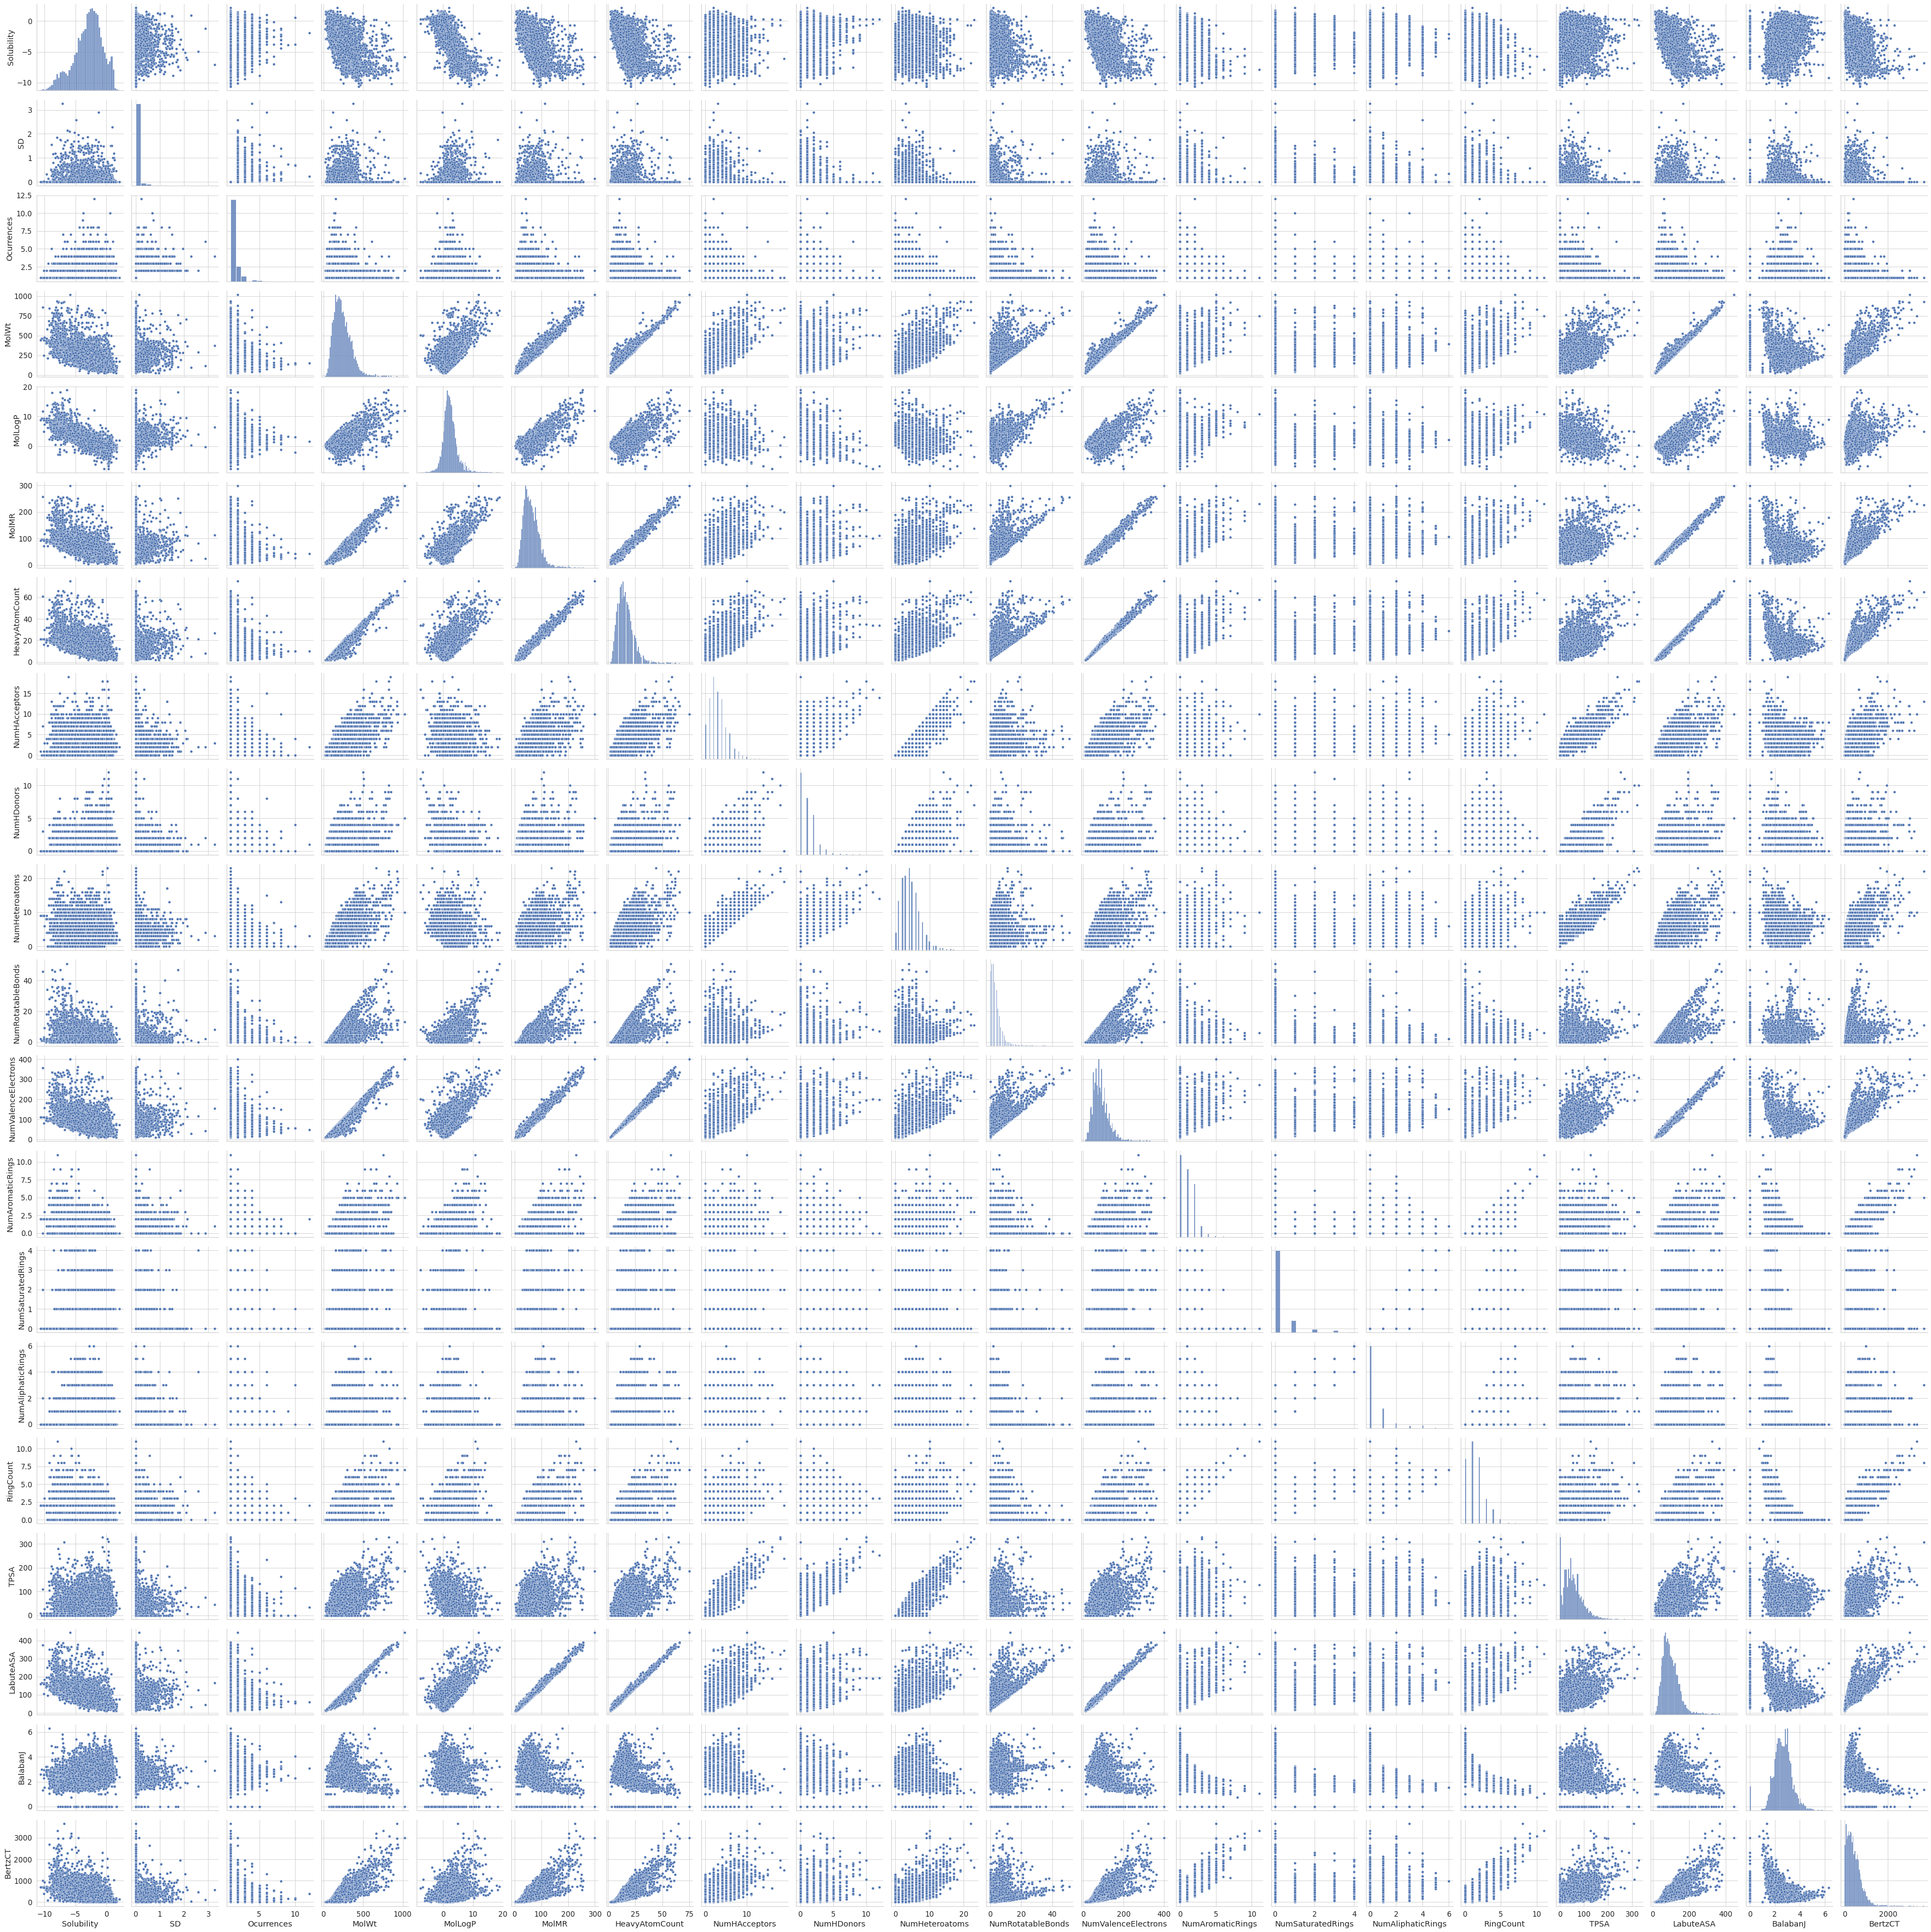

In [11]:
#collapse_output
sns.pairplot(data)

An even better way to visualize the correlation between features is to plot a heatmap using ```sns.heatmap```.

First, we calculate Pearson's R coefficient for each pair of features. 

The largest diagonal corresponds to self correlation for each feature (e.g. MolWt x MolWt), and is always 1. The most interesting part are the other values, showing the correlation between each pair. 

As we can see from the heatmap, some features have a high linear correlation, such as MolWt and LabuteASA (0.98), MolWt and MolMR (0.96), HeavyAtomCount and NumValenceElectrons (0.99). The highest $r$ for BalabanJ is with RingCount (-0.64). For BertzCT, the highest correlations are with features that encode the molecular complexity, such as molecular weight, molar refractivity and number of heavy atoms, which is consistent with its definition. Thus, the correlations in the heatmap correspond to what we expect from the molecular properties represented by each feature. 

In [53]:
corr = data[descriptors+['Solubility']].corr()

<AxesSubplot:>

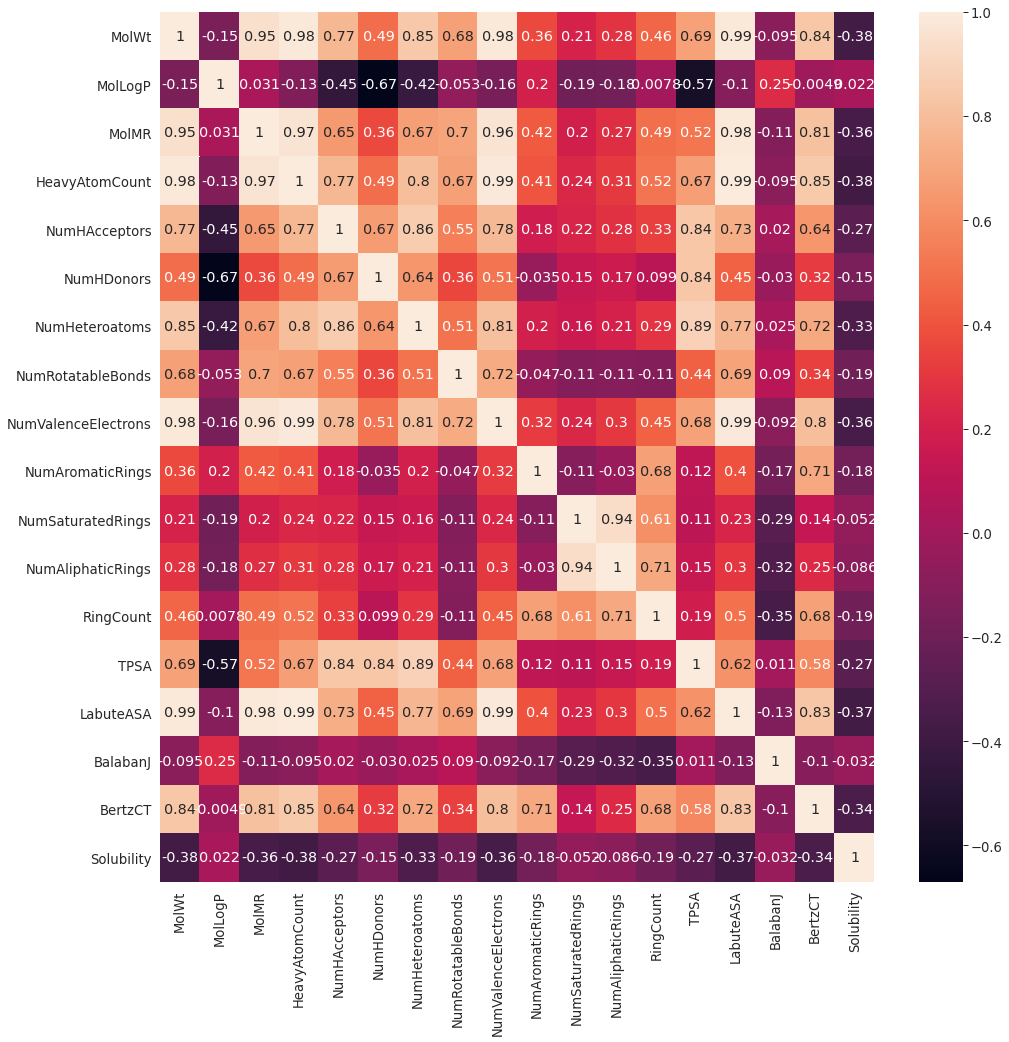

In [54]:
sns.heatmap(corr, annot=True)

Let's zoom in into the last row of the heatmap that shows the correlations between our target and each feature. The sliced heatmap can tell us a great story about the target variable and the features. For instance, the negative correlation between molecular weight, logP and molar refractivity is in accordance with experimental data. 

In addition, we can see that the number of hydrogen bond donors shows a weak positive correlation with solubility, while the number of H-bond acceptors shows a very weak negative correlation. This is interesting because it shows us that the potential of intermolecular interactions can have an impact on solubility. In general, [increasing of H-bond donors and acceptors also increases solubility](https://www.sciencedirect.com/science/article/abs/pii/S0022354915508666). However, if the molecule can both donate and accept H-bonds, a decrease in solubility might happen due to intermolecular interactions in crystals leading to increased melting point. The low correlations between Hbond capacity and solubility for this dataset might be a reflection of the high number of molecules with low solubilities; which is an indication of **bias** in our data. 


<AxesSubplot:>

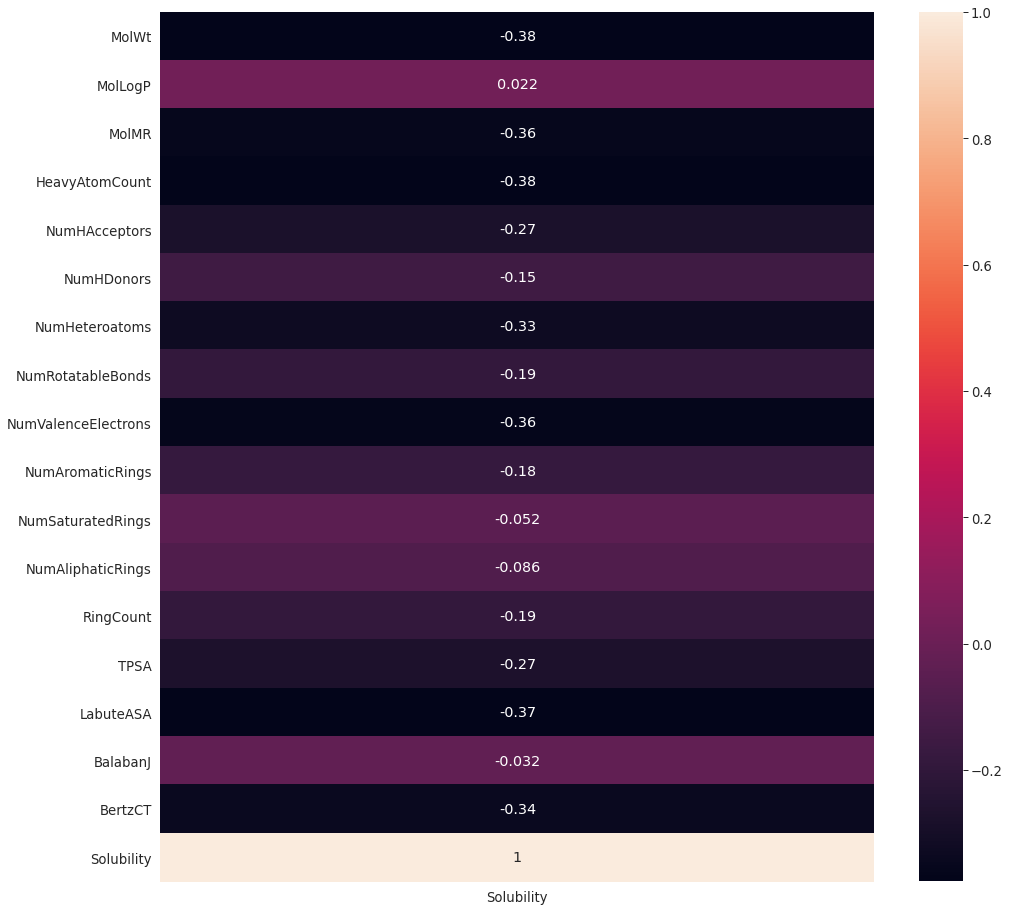

In [56]:
sns.heatmap(pd.DataFrame(corr.iloc[-1]),annot=True)

In [51]:
high_soluble = data[data['Solubility']>0.0]


soluble = data[(data['Solubility']>-2) & (data['Solubility']<=0)]


slight_soluble = data[(data['Solubility']>-4.0) & (data['Solubility']<=-2.0)]


insoluble = data[data['Solubility']<=-4.0]

# References

**Molecular descriptors**

https://northstar-www.dartmouth.edu/doc/MOE/Documentation/quasar/descr.htm#KH

http://www.codessa-pro.com/descriptors/index.htm


**Normality tests**

Machine learning mastery post: https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

Shapiro-Wilk test: https://www.itl.nist.gov/div898/handbook/prc/section2/prc213.htm

Anderson-Darling test : https://www.itl.nist.gov/div898/handbook/prc/section2/prc21.htm


GraphPad entry: https://www.graphpad.com/guides/prism/latest/statistics/stat_choosing_a_normality_test.htm

# **Fin**

# Sample class to sanitize the dataset

In [ ]:
#collapse
from unittest.mock import *
from rdkit import Chem
from tqdm.notebook import tqdm
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
from rdkit.Chem.SaltRemover import SaltRemover as saltremover
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser
from rdkit.Chem import AllChem, SanitizeMol
from rdkit import rdBase
from rdkit.Chem import rdmolops
from fastcore.all import *
rdBase.DisableLog('rdApp.error')
rdBase.DisableLog('rdApp.info')

In [ ]:
#collapse
_saltremover = saltremover()
_unwanted = Chem.MolFromSmarts('[!#1!#6!#7!#8!#9!#15!#16!#17!#35!#53]')

def _initialiseNeutralisationReactions():
  patts = (
        # Imidazoles
        ('[n+;H]', 'n'),
        # Amines
        ('[N+;!H0]', 'N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]', 'O'),
        # Thiols
        ('[S-;X1]', 'S'),
        #Amidines
        ('[C+](N)', 'C(=N)'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]', 'N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]', 'N'),
        # Tetrazoles
        ('[n-]', '[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]', 'S'),
        # Amides
        ('[$([N-]C=O)]', 'N'),
    )
  return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

def neutralise(mol,reactions=None):
  reactions = _initialiseNeutralisationReactions()
  replaced = False
  for i,(reactant, product) in enumerate(reactions):
    while mol.HasSubstructMatch(reactant):
      replaced = True
      rms = AllChem.ReplaceSubstructs(mol, reactant, product)
      mol = rms[0]

  if replaced:
    rdmolops.Cleanup(mol)
    rdmolops.SanitizeMol(mol)
    mol = rdmolops.RemoveHs(mol, implicitOnly=False, updateExplicitCount=False, sanitize=True)
    return mol
  else:
    rdmolops.Cleanup(mol)
    rdmolops.SanitizeMol(mol)
    mol = rdmolops.RemoveHs(mol, implicitOnly=False, updateExplicitCount=False, sanitize=True)
    return mol

def _rare_filters(mol):
  if mol:
    cyano_filter = "[C-]#[N+]"
    oh_filter = "[OH+]"
    sulfur_filter = "[SH]"
    sulfur_filter2 = "[SH2]"
    iodine_filter1 = "[IH2]"
    iodine_filter2 = "[I-]"
    iodine_filter3 = "[I+]"

    if not mol.HasSubstructMatch(Chem.MolFromSmarts(cyano_filter)) \
      and not mol.HasSubstructMatch(Chem.MolFromSmarts(oh_filter)) \
      and not mol.HasSubstructMatch(Chem.MolFromSmarts(sulfur_filter2)) \
      and not mol.HasSubstructMatch(Chem.MolFromSmarts(iodine_filter1)) \
      and not mol.HasSubstructMatch(Chem.MolFromSmarts(iodine_filter2)) \
      and not mol.HasSubstructMatch(Chem.MolFromSmarts(iodine_filter3)) \
      and not mol.HasSubstructMatch(Chem.MolFromSmarts(sulfur_filter)):
      return mol

def set_active(row):
    active = 'Inactive'
    if row['standard_value'] <= 10000: active = 'Active'
    return active


In [ ]:
#collapse
class SanitizeDataset():
    def __init__(self,df,smiles_column:str='Smiles',activity_column = None, sep:str='\t'):
        self.df, self.smiles_column, self.activity_column = df, smiles_column, activity_column

@patch
@delegates(SanitizeDataset)
def add_mol_column(x:SanitizeDataset, smiles, **kwargs):
    if type(smiles) == str and smiles != '':

        mol = Chem.MolFromSmiles(smiles) #.replace('@','').replace('/','').replace("\\","")
        return mol
    else:
        return None

@patch
@delegates(SanitizeDataset)
def remove_unwanted(x:SanitizeDataset,mol, **kwargs):
    if not mol.HasSubstructMatch(_unwanted) and (sum([atom.GetIsotope() for atom in mol.GetAtoms()])==0):
        return mol
@patch
@delegates(SanitizeDataset)
def _remove_salts(x:SanitizeDataset,mol, **kwargs):
    mol = _saltremover.StripMol(mol, dontRemoveEverything=True)
    mol = _saltremover.StripMol(mol, dontRemoveEverything=True)
    mol = rdmolops.RemoveHs(mol, implicitOnly=False, updateExplicitCount=False, sanitize=True)
    mol = x._getlargestFragment(mol)
    return mol

@patch
@delegates(SanitizeDataset)
def _getlargestFragment(x:SanitizeDataset, mol, **kwargs):
    frags = rdmolops.GetMolFrags(mol, asMols=True, sanitizeFrags=True)
    maxmol = None
    for mol in frags:
        if mol is None:
            continue
        if maxmol is None:
            maxmol = mol
        if maxmol.GetNumHeavyAtoms() < mol.GetNumHeavyAtoms():
            maxmol = mol
    return maxmol

@patch
@delegates(SanitizeDataset)
def is_valid(x:SanitizeDataset, mol, min_heavy_atoms = 1, max_heavy_atoms = 9999, **kwargs):
    if mol:
        return _rare_filters(mol) if min_heavy_atoms < mol.GetNumHeavyAtoms() < max_heavy_atoms else None
    return None

@patch
@delegates(SanitizeDataset)
def canonilize(x:SanitizeDataset, mol, **kwargs):
    if mol:
        return Chem.MolToSmiles(mol, isomericSmiles = True) if mol.GetNumHeavyAtoms()>0 else print(type(mol))
    else:
        return None

@patch
@delegates(SanitizeDataset)
def process_data(x:SanitizeDataset, **kwargs):

    x.df = x.df.loc[~x.df[x.smiles_column].isnull()]

    x.df['mol'] = x.df[x.smiles_column].apply(x.add_mol_column)
    x.df = x.df.loc[~x.df['mol'].isnull()]

    x.df['mol'] = x.df['mol'].apply(x.remove_unwanted)
    x.df['mol'] = x.df['mol'].apply(_rare_filters)
    x.df = x.df.loc[~x.df['mol'].isnull()]

    x.df['mol'] = x.df['mol'].apply(x._remove_salts)
    x.df['mol'] = x.df['mol'].apply(neutralise)
    x.df['mol'] = x.df['mol'].apply(x.is_valid)
    x.df = x.df.loc[~x.df['mol'].isnull()]  

    x.df['processed_smiles'] = x.df['mol'].apply(lambda x : Chem.MolToSmiles(x))
    x.df = x.df.loc[~x.df['processed_smiles'].isnull()]
    x.df.drop_duplicates(subset='processed_smiles',inplace=True)
    return x.df

In [ ]:
#collapse
sanitizer = SanitizeDataset(df=df, smiles_column='SMILES',activity_column = 'Solubility', sep=',')